In [1]:
# import sys
# !{sys.executable} -m pip install yellowbrick

In [2]:
import json
import re
import string
import pymorphy2
import stop_words
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem.snowball import RussianStemmer
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from yellowbrick.classifier import ClassPredictionError
# модели
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

In [3]:
# настраиваемые параметры
article_filename = "articles.json" # путь до файла с полным сохранением статей
vectorized_filename = "vectorized_train.npy"
categories = ["entertainment", "auto", "sport", "health"]

In [4]:
news = []
with open(article_filename, encoding="utf-8") as file:
    for line in file:
        news.append(json.loads(line))
data = pd.DataFrame(news)
data.head()

,article_id,title,category,tags,text
0,https://www.nn.ru/text/entertainment/2023/01/1...,Кто такой цуцик и где раки зимуют? Попробуйте ...,entertainment,"Развлечения,Знания,История,Развлечения,Тест,Фр...","Если бы не было фразеологизмов, наша речь (а в..."
1,https://www.nn.ru/text/entertainment/2023/01/1...,Снова как мальчик: Филипп Киркоров резко помол...,entertainment,"Развлечения,Филипп Киркоров,Звезды,Шоу-бизнес","Редко кто может похвастаться тем, что после ка..."
2,https://www.nn.ru/text/entertainment/2023/01/1...,2023 — это колесница: каким будет год Черного ...,entertainment,"Развлечения,Гороскоп,Нумеролог,Прогноз нумерол...","Если присмотреться внимательнее, то можно обна..."
3,https://www.nn.ru/text/entertainment/2023/01/1...,Вам не решить: 10 советских задач в картинках ...,entertainment,"Развлечения,СССР,Интересный тест,Тест,Внимание...",Ставить опыты над возможностями человеческих п...
4,https://www.nn.ru/text/entertainment/2023/01/1...,Не только «Ёлки-9»: что больше всего приглянул...,entertainment,Развлечения,Wink представляет самые популярные фильмы и се...


In [5]:
data.shape

(4057, 5)

# 1. Предобработка собранного корпуса (датасет новостей): удаление знаков препинания и лишних символов, токенизация, приведение к нормальной форме, удаление стоп-слов.

### Преобразование текста

In [6]:
EXCLUDE_SYMBOLS_STR = u''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                                '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                                '\x7f', '\xad', '¤', '\xa0', '\u200e'])

In [7]:
corpus = [re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text) for text in data["text"]] # удаление ссылок
corpus = [text.lower() for text in corpus] # приведение к нижнему регистру
corpus = [re.sub(r'[\d\w-]{1,}\.(ru|com|ua)' , '', text) for text in corpus] # удаление неполных ссылок
# в статьях нет \n или \t

regex_punct = re.compile('[%s]' % re.escape(string.punctuation))
corpus = [regex_punct.sub('', text) for text in corpus] # убираем пунктуацию

regex_dig = re.compile('[%s]' % re.escape(string.digits))
corpus = [regex_dig.sub('', text) for text in corpus] # убираем цифры

regex_symb = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
corpus = [regex_symb.sub(' ', text) for text in corpus] # убираем дополнительные символы

corpus = [re.sub(' +' , ' ', text) for text in corpus] # оставляем максимум 1 пробел
corpus = [text.strip() for text in corpus] # удаляем лишние пробелы в начале и конце статей

### Токенизация и пропуск стоп-слов

In [8]:
morph = pymorphy2.MorphAnalyzer()

In [9]:
corpus_tokens = [] # для токенов из строк
inds_to_drop = [] # статьи, что будут убраны

for i, sentence in enumerate(corpus):
    tmp_tokens = [] # временный массив с токенами
    sp = sentence.split() # разделяем строку по пробелам
    for word in sp: # проходим по словам в строке
        if word not in stop_words.get_stop_words('ru'): # если слова нет в списке стоп-слов для русского языка
            if morph.word_is_known(word): # проверяет, что слово есть в словаре
                tmp_tokens.append(word) # добавляем токен
    if len(tmp_tokens) > 0: # если после попытки токенизации строки получилось хоть сколько-то токенов, то записываем их в corpus_tokens
        corpus_tokens.append(tmp_tokens)
    else: # иначе - добавляем строку в дропы
        inds_to_drop.append(i)
        
print(len(corpus_tokens), len(inds_to_drop)) # в данном случае, все статьи были токенизированы

4057 0


### Приведение к нормальной форме

In [10]:
stemmer = RussianStemmer() # стеммер для нахождения основы слова

In [11]:
corpus_tokens_stem = []

for i, tokens in enumerate(corpus_tokens):
    tmp = [stemmer.stem(word) for word in tokens] # проходимся стеммером по всем токенам для получения основы слова-токена
    corpus_tokens_stem.append(tmp)
corpus_tokens_stem = np.asarray(corpus_tokens_stem)

C:\Users\User\Documents\TEMP\ipykernel_55648\1241036772.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  corpus_tokens_stem = np.asarray(corpus_tokens_stem)


Частота встречи различного числа основ (токенов)

In [12]:
diffs = np.asarray([len(tokens) for tokens in corpus_tokens_stem]) # массив числа основ токенов, оставшихся в статьях
print(diffs.min()) # минимум основ (нормализованных токенов) = 10

10


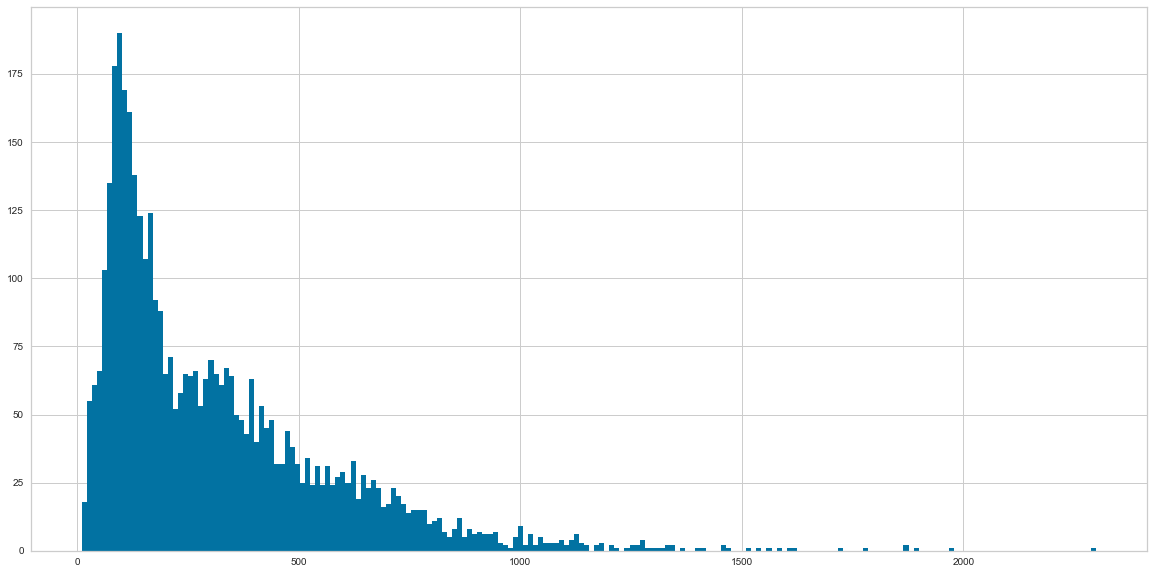

In [13]:
plt.figure(figsize=(20, 10))
plt.hist(diffs, bins=200)
plt.grid(True)

Число встреченных основ (словарь)

In [14]:
vocab = np.unique(np.concatenate(corpus_tokens_stem).flatten()).tolist()
print(len(vocab))

37108


Сбор датасета

In [15]:
dataset = []
for i in range(len(corpus_tokens_stem)):
    dataset.append([' '.join(corpus_tokens_stem[i]), data["category"][i]])
dataset = pd.DataFrame(dataset, columns=["text", "category"])

In [16]:
dataset

,text,category
0,фразеологизм реч возможн скучн интересн пользо...,entertainment
1,редк похваста каникул набра лишн килограмм зар...,entertainment
2,присмотрет внимательн обнаруж повсюд окружа ци...,entertainment
3,став опыт возможн человеческ познан придума по...,entertainment
4,представля сам популярн фильм сериал смотрел н...,entertainment
...,...,...
4052,перв новост появ полутор мир охват пандем мног...,health
4053,официальн представител кремл дмитр песк проком...,health
4054,успел росс отойт трет волн коронавирус пришл ч...,health
4055,летн екатеринбуржец евген реш подел истор проч...,health


# 2. Векторизация текста

Разбиение на тренировочную/тестовую выборку

In [17]:
data_train, data_test = train_test_split(dataset, test_size=0.1)
print(len(data_train), len(data_test))

3651 406


In [18]:
data_train.category.value_counts()

health           928
auto             924
sport            903
entertainment    896
Name: category, dtype: int64

Векторизация

In [19]:
vectorizer = TfidfVectorizer(vocabulary=vocab)
vectorizer.fit(dataset["text"])

TfidfVectorizer(vocabulary=['а', 'аа', 'аарон', 'аб', 'абабковск', 'абажур',
                            'абаз', 'абаим', 'абака', 'абакан', 'абакум',
                            'абакумов', 'абандон', 'абашкин', 'аббатств',
                            'аббревиатур', 'абд', 'абдалл', 'абдельазиз',
                            'абдом', 'абдоминальн', 'абдрахманов', 'абдряхим',
                            'абдул', 'абдула', 'абдулаев', 'абдулкерим',
                            'абдулл', 'абдулмажид', 'абдулмеджид', ...])

In [20]:
data_train_vect = vectorizer.transform(data_train["text"])
data_train_cat = data_train["category"]
data_test_vect = vectorizer.transform(data_test["text"])
data_test_cat = data_test["category"]

Пример векторизованного текста

In [21]:
print(dataset["text"].iloc[15])
print(vectorizer.transform([dataset["text"].iloc[15]]).toarray()[0])
print(vectorizer.transform([dataset["text"].iloc[15]]))

новогодн праздник нача большинств россия вперед цел недел беззаботн отдых провест сам главн сохран новогодн настроен момент придет выход работ подобра фильм помогут продл ощущен праздник надолг стран драм выпуск продолжительн минут рейтинг рейтинг американск рождественск классик оскароносн фильм пожил мужчин крис канун рождеств уговор сыгра парад устроен крупн магазин актер долж игра нап стельк успех парад крис получ работ магазин отказа продава дет залежа игрушк отправл покупател конкурент крис настаива настоя параллельн мужчин реш помоч девочк росл отц хотел свест вмест мат сосед юрист фред кстат классическ картин вышедш современ ремейк выпуст главн рол сыгра ричард элизабет мар уилсон стран мелодрам выпуск продолжительн минут рейтинг рейтинг геро джон кейт наход друг друг сует предновогодн город реш наслажда обществ друг друг усложн испыта судьб записа номер телефон купюр книг деньг обменя книг сдал букинист сведет вмест стран выпуск продолжительн минут рейтинг рейтинг париж канун р

# 3. Классификация категорий собственного новостного корпуса с помощью моделей классического машинного обучения.

Использование моделей для предсказания:

1) KNN (K-Nearest Neighbors — K Ближайших Соседей)

In [22]:
parameters_knn = { # параметры для KNN модели
    "n_neighbors": [3, 5, 10, 15],
    "weights": ["uniform", "distance"],
    "metric": ["minkowski", "manhattan"]
}

gs_knn = GridSearchCV( # параметры GridSearchCV
    KNeighborsClassifier(),
    parameters_knn,
    verbose = 1,
    cv=3,
    n_jobs=-1
)

gs_knn_res = gs_knn.fit(data_train_vect, data_train_cat) # подбираем лучшие параметры для оценщика
pred_knn = gs_knn_res.best_estimator_.predict(data_test_vect) # предсказываем
print(metrics.classification_report(data_test_cat, pred_knn)) # выписываем основные метрики

Fitting 3 folds for each of 16 candidates, totalling 48 fits
               precision    recall  f1-score   support

         auto       0.96      0.97      0.96        94
entertainment       0.94      0.92      0.93       104
       health       0.91      0.97      0.94        93
        sport       0.96      0.92      0.94       115

     accuracy                           0.94       406
    macro avg       0.94      0.95      0.94       406
 weighted avg       0.94      0.94      0.94       406



2) SGD (Stochastic Gradient Descent — Стохастический Градиентный Спуск)

In [23]:
parameters_sgd = {
    "penalty": ["elasticnet", "l2", "l1"],
    "alpha": [0.0001, 0.01, 0.1, 0.5, 1, 5],
    "max_iter": [100, 500, 1000, 2000],
    "learning_rate": ["optimal", "invscaling", "adaptive"],
    "eta0": [1, 10]
}

gs_sgd = GridSearchCV(
    SGDClassifier(),
    parameters_sgd,
    verbose = 1,
    cv=3,
    n_jobs=-1
)

gs_sgd_res = gs_sgd.fit(data_train_vect, data_train_cat)
pred_sgd = gs_sgd_res.best_estimator_.predict(data_test_vect)
print(metrics.classification_report(data_test_cat, pred_sgd))

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
               precision    recall  f1-score   support

         auto       0.99      0.98      0.98        94
entertainment       0.93      0.99      0.96       104
       health       0.99      0.98      0.98        93
        sport       1.00      0.96      0.98       115

     accuracy                           0.98       406
    macro avg       0.98      0.98      0.98       406
 weighted avg       0.98      0.98      0.98       406



3) Логистическая регрессия

In [26]:
parameters_log = {
    "penalty": ["l2", "l1"],
    "C": np.logspace(-4, 4, 10),
    "solver": ["saga"],
    "max_iter": [500, 1000]
}

gs_log = GridSearchCV(
    LogisticRegression(),
    parameters_log,
    verbose = 1,
    cv=3,
    n_jobs=-1
)

gs_log_res = gs_log.fit(data_train_vect, data_train_cat)
pred_log = gs_log_res.best_estimator_.predict(data_test_vect)
print(metrics.classification_report(data_test_cat, pred_log))

Fitting 3 folds for each of 40 candidates, totalling 120 fits
               precision    recall  f1-score   support

         auto       0.98      0.98      0.98        94
entertainment       0.94      0.99      0.96       104
       health       0.98      0.98      0.98        93
        sport       1.00      0.95      0.97       115

     accuracy                           0.97       406
    macro avg       0.97      0.97      0.97       406
 weighted avg       0.97      0.97      0.97       406



c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


4) Случайный лес (Random Forest Classifier)

In [27]:
parameters_forest = {
    "n_estimators": [5, 10, 25, 100, 1000],
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 5, 25, 100],
    "min_samples_split": [2, 5, 10],
    "max_features": [None, "sqrt"]
}

gs_forest = GridSearchCV(
    RandomForestClassifier(),
    parameters_forest,
    verbose = 1,
    cv=3,
    n_jobs=-1
)

gs_forest_res = gs_forest.fit(data_train_vect, data_train_cat)
pred_forest = gs_forest_res.best_estimator_.predict(data_test_vect)
print(metrics.classification_report(data_test_cat, pred_forest))

Fitting 3 folds for each of 240 candidates, totalling 720 fits
               precision    recall  f1-score   support

         auto       1.00      1.00      1.00        94
entertainment       0.92      0.98      0.95       104
       health       0.97      0.96      0.96        93
        sport       0.98      0.93      0.96       115

     accuracy                           0.97       406
    macro avg       0.97      0.97      0.97       406
 weighted avg       0.97      0.97      0.97       406



5) Наивный байесовский классификатор (Naive Bayes classifier)

In [28]:
parameters_nb = {
    "alpha": [0.00001, 0.0001, 0.01, 0.1, 1] 
}

gs_nb = GridSearchCV(
    MultinomialNB(),
    parameters_nb,
    verbose = 1,
    cv=3,
    n_jobs=-1
)

gs_nb_res = gs_nb.fit(data_train_vect, data_train_cat)
pred_nb = gs_nb_res.best_estimator_.predict(data_test_vect)
print(metrics.classification_report(data_test_cat, pred_nb))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
               precision    recall  f1-score   support

         auto       0.97      0.96      0.96        94
entertainment       0.92      0.98      0.95       104
       health       0.95      0.96      0.95        93
        sport       1.00      0.94      0.97       115

     accuracy                           0.96       406
    macro avg       0.96      0.96      0.96       406
 weighted avg       0.96      0.96      0.96       406



6) SVC (C-Support Vector Classification — Метод Опорных Векторов)

In [30]:
parameters_svc = {
    "C":  [1, 10, 100, 1000],
    "gamma": [0.001, 0.0001, "scale"],
    "kernel": ["rbf", "linear", "poly"]
}

gs_svc = GridSearchCV(
    SVC(),
    parameters_svc,
    verbose = 1,
    cv=3,
    n_jobs=-1
)

gs_svc_res = gs_svc.fit(data_train_vect, data_train_cat)
pred_svc = gs_svc_res.best_estimator_.predict(data_test_vect)
print(metrics.classification_report(data_test_cat, pred_svc))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
               precision    recall  f1-score   support

         auto       0.99      0.98      0.98        94
entertainment       0.91      0.99      0.95       104
       health       0.99      0.97      0.98        93
        sport       1.00      0.95      0.97       115

     accuracy                           0.97       406
    macro avg       0.97      0.97      0.97       406
 weighted avg       0.97      0.97      0.97       406



# 4. Анализ полученных результатов. Сравнение метрики качества, визуализация, выводы.

In [147]:
data_test["category"].value_counts()

sport            115
entertainment    104
auto              94
health            93
Name: category, dtype: int64

In [148]:
models = [gs_knn_res, gs_sgd_res, gs_log_res, gs_forest_res, gs_nb_res, gs_svc_res]
names = ["KNN", "SGD", "Лог. регрессия", "Случайный лес", "Naive Bayes", "SVC"]
preds = [pred_knn, pred_sgd, pred_log, pred_forest, pred_nb, pred_svc]
labels = sorted(dataset["category"].unique())

Лучшие параметры

In [149]:
for name, model in zip(names, models):
    print(name, model.best_params_)

KNN {'metric': 'minkowski', 'n_neighbors': 10, 'weights': 'distance'}
SGD {'alpha': 0.0001, 'eta0': 1, 'learning_rate': 'adaptive', 'max_iter': 100, 'penalty': 'l2'}
Лог. регрессия {'C': 1291.5496650148827, 'max_iter': 500, 'penalty': 'l2', 'solver': 'saga'}
Случайный лес {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 1000}
Naive Bayes {'alpha': 0.1}
SVC {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}


<pre>
Для моделей KNN, SGD, Naive Bayes, SVC подбор параметров и обучение прошли относительно быстро, в то время как для 
Логистической регрессии и Случайного леса это заняло на порядок больше времени.
</pre>

Визуализация предсказаний

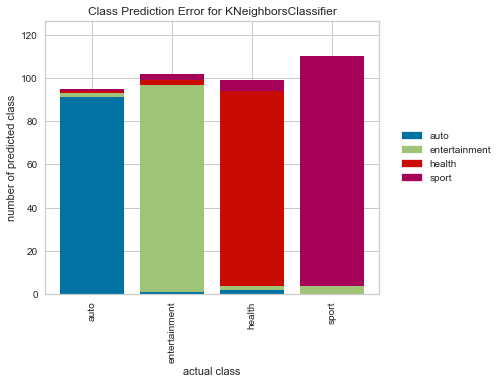

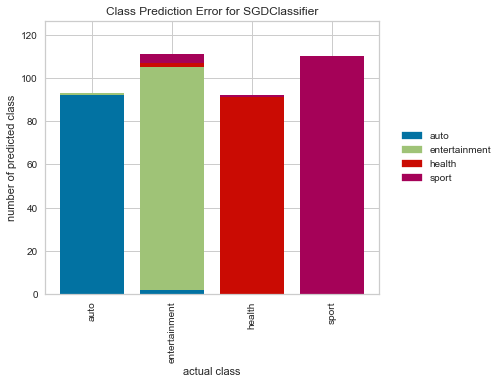

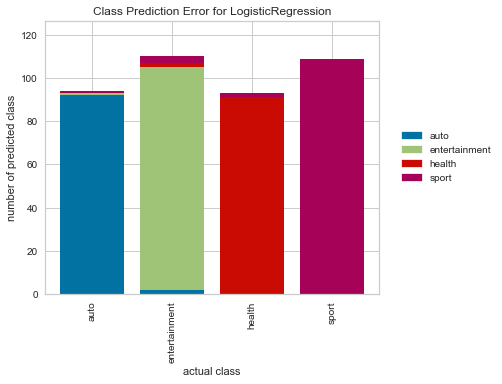

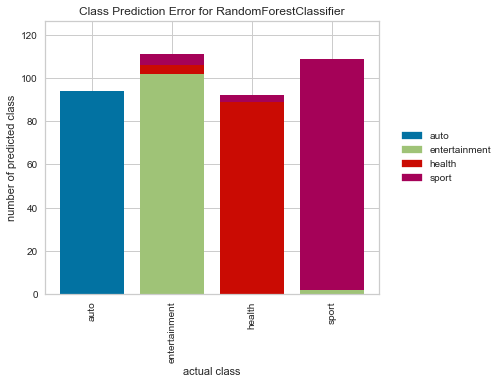

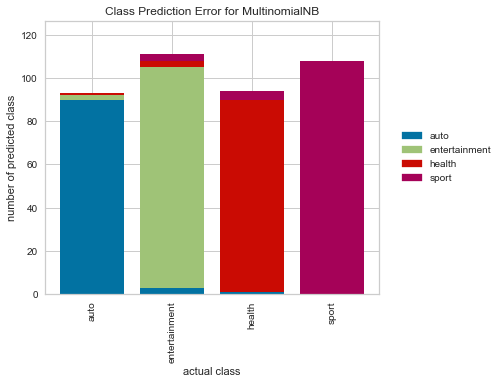

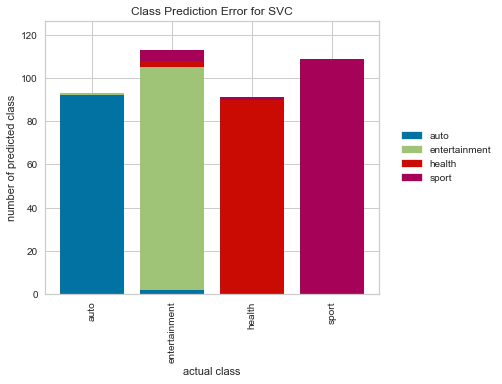

In [150]:
for model in models:
    model.best_estimator_.class_counts_ = 4
    visualizer = ClassPredictionError(
         model.best_estimator_, classes=labels, is_fitted=True
    )
    visualizer.score(data_test_vect, data_test_cat)
    visualizer.show()

Confusion matrix

Model: KNN


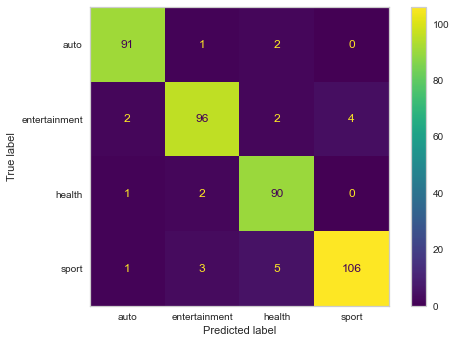

Model: SGD


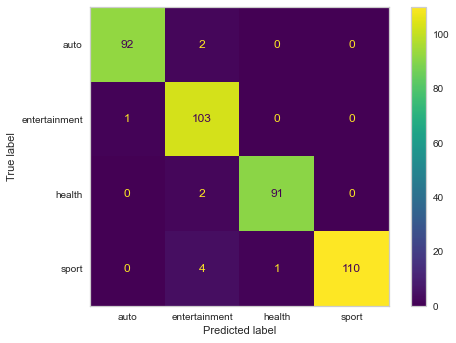

Model: Лог. регрессия


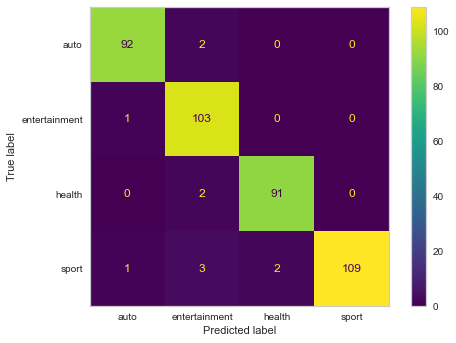

Model: Случайный лес


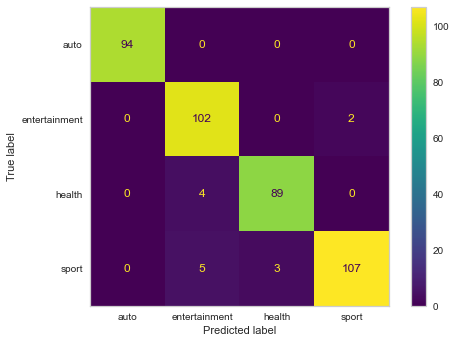

Model: Naive Bayes


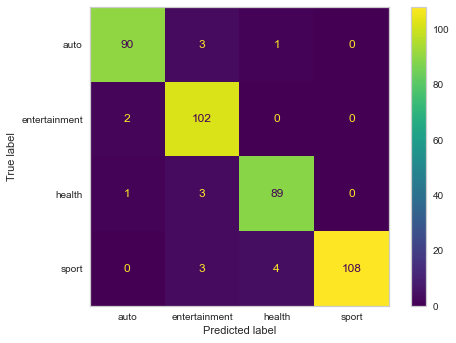

Model: SVC


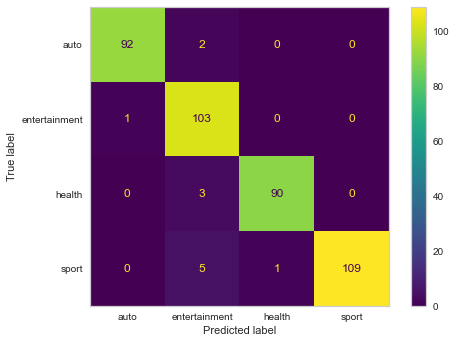

In [151]:
for name, pred in zip(names, preds):
    print(f"Model: {name}")
    metrics.ConfusionMatrixDisplay(confusion_matrix = metrics.confusion_matrix(data_test_cat, pred),
                                   display_labels = labels).plot()
    plt.grid(False)
    plt.show()

Сравнение по accuracy:

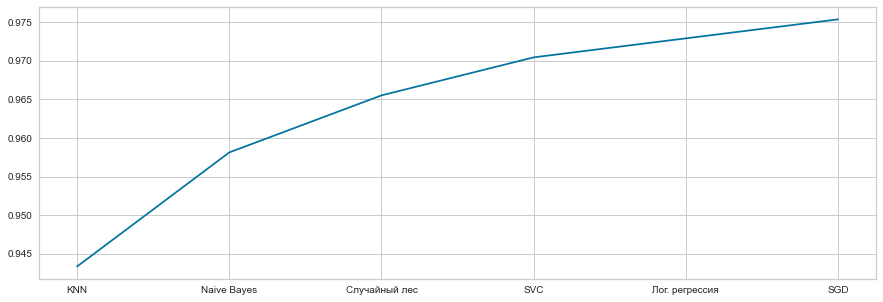

In [152]:
plt.figure(figsize=(15, 5))

acc, names_acc = zip(*sorted(zip([metrics.accuracy_score(data_test_cat, pred) for pred in preds], names)))

plt.grid(True)
plt.plot(names_acc, acc)

Сравнение по F1 мере:

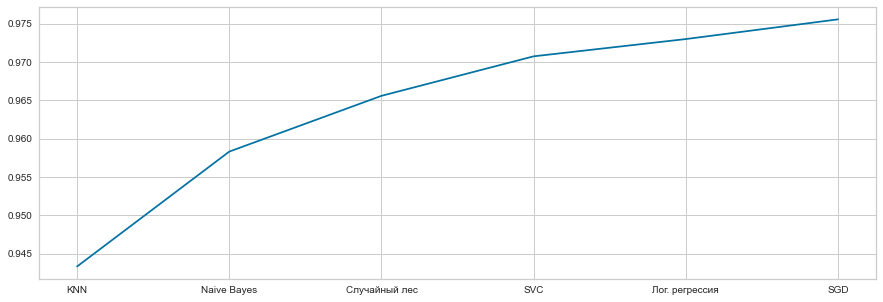

In [153]:
plt.figure(figsize=(15, 5))

f1s, names_f1 = zip(*sorted(zip([metrics.f1_score(data_test_cat, pred, average="weighted") for pred in preds], names)))

plt.grid(True)
plt.plot(names_f1, f1s)

Графики получились практически одинаковыми. На всех лучшие показатели у SGD модели и худшие у KNN.

Feature importance для моделей (топ 10 самых важных основ слов для каждой модели при классификации по категориям):

In [154]:
# считаем feature importance для моделей
# у KNN нет такого показателя
# у SVC лучшим kernel-ом стал 'rbf', для которого нет атрибута coef_
# у случайного леса, feature_importances_ не разделяются на разные классы
# у Naive Bayes используется логарифмическая вероятность признаков данного класса, P(x_i|y)
for model, name in zip(models, names):
    if name in ["KNN", "Случайный лес", "SVC"]:
        continue
    print(f"Модель: {name}")
    for i, category in enumerate(model.classes_):
        print(f"\tДля категории: {category}")
        importances = []
        try:
            importances = pd.Series(model.best_estimator_.coef_[i]).sort_values(ascending=False)[:10:]
        except:               
            importances = pd.Series(model.best_estimator_.feature_log_prob_[i]).sort_values(ascending=False)[:10:]
        for index, feature in zip(importances.index, importances):
            print(f"\t\tИндекс: {index} \t Значение: {feature} \t Основа слова: {vectorizer.get_feature_names_out()[index]}")

Модель: SGD
	Для категории: auto
		Индекс: 3957 	 Значение: 3.804889885986069 	 Основа слова: водител
		Индекс: 193 	 Значение: 3.3533594542422143 	 Основа слова: автомобил
		Индекс: 14858 	 Значение: 2.388691868050498 	 Основа слова: машин
		Индекс: 7838 	 Значение: 2.3359176390243137 	 Основа слова: дорог
		Индекс: 20780 	 Значение: 1.7797440614955853 	 Основа слова: парковк
		Индекс: 5752 	 Значение: 1.6667599079360986 	 Основа слова: гибдд
		Индекс: 134 	 Значение: 1.4762578733370508 	 Основа слова: авт
		Индекс: 192 	 Значение: 1.3282851070140032 	 Основа слова: автомоб
		Индекс: 32816 	 Значение: 1.2828154484257175 	 Основа слова: транспортн
		Индекс: 8066 	 Значение: 1.2745209889023745 	 Основа слова: дтп
	Для категории: entertainment
		Индекс: 36185 	 Значение: 1.5812828716744338 	 Основа слова: шо
		Индекс: 12687 	 Значение: 1.5568413459252588 	 Основа слова: концерт
		Индекс: 34592 	 Значение: 1.4980934570111477 	 Основа слова: фильм
		Индекс: 13432 	 Значение: 1.421282504852

### Финальная оценка

<pre>
1) KNN: accuracy 0.94
               precision    recall  f1-score   support
         auto       0.96      0.97      0.96        94
entertainment       0.94      0.92      0.93       104
       health       0.91      0.97      0.94        93
        sport       0.96      0.92      0.94       115
  Ошибки были при предсказании всех классов. Стоит отметить, что записи из категории "sport", KNN путал только с категорией "entertainment". В целом, модель показала себя неплохо, так как быстро обучилась и выдала приличные значения метрик, хоть и одни из самых плохих, по сравнению с другими моделями.

2) SGD: accuracy 0.98
               precision    recall  f1-score   support
         auto       0.99      0.98      0.98        94
entertainment       0.93      0.99      0.96       104
       health       0.99      0.98      0.98        93
        sport       1.00      0.96      0.98       115
  Это модель, показавшая лучшие результаты и занявшая первое место по accuracy и F1. Заметные ошибки были только при предсказании категории "entertainment". Обучение этой модели не заняло много времени. Как итог - самая предпочтительная модель для использования.
3) Логистическая регрессия: accuracy 0.97
               precision    recall  f1-score   support
         auto       0.98      0.98      0.98        94
entertainment       0.94      0.99      0.96       104
       health       0.98      0.98      0.98        93
        sport       1.00      0.95      0.97       115
  Результаты модели логистической регрессии очень схожи с SGD, однако, в основном они уступают, хоть и ненамного. Главным минусом же является то, что обучение заняло на порядок больше времени.
4) Случайный лес: accuracy 0.97
               precision    recall  f1-score   support
         auto       1.00      1.00      1.00        94
entertainment       0.92      0.98      0.95       104
       health       0.97      0.96      0.96        93
        sport       0.98      0.93      0.96       115
  Случайный лес - единственная модель, идеально предсказавшая категорию "auto". Однако, с другими категориями всё не так гладко; результаты модели являются чем-то средним между наивной Байесовской моделью и SVC. Обучение данной модели заняло довольно много времени, но это может быть связано с большим числом параметров для подбора.
5) Наивный байесовский классификатор: accuracy 0.96
               precision    recall  f1-score   support
         auto       0.97      0.96      0.96        94
entertainment       0.92      0.98      0.95       104
       health       0.95      0.96      0.95        93
        sport       1.00      0.94      0.97       115
  Это модель, показавшая результаты чуть лучше, чем KNN. К основным плюсам — обучение, как и у KNN, было недолгим.
6) SVC: accuracy 0.97
               precision    recall  f1-score   support
         auto       0.99      0.98      0.98        94
entertainment       0.91      0.99      0.95       104
       health       0.99      0.97      0.98        93
        sport       1.00      0.95      0.97       115
  SVC - модель, показавшая результаты выше среднего. По значениею метрик accuracy и F1, SVC занимает третье место (после SGD и Логистической регрессии) из шести. Главной слабость оказалось предсказание категории "entertainment", что свойственно всем рассматриваемым моделям.
  
  
  Итог: лучшая модель - SGD из-за наивысшх метрик, достаточно точных предсказаний и быстрого обучения.
</pre>